# Testing the performance of agents from Ray Repository

Github Repository: https://github.com/ray-project/ray

Conda environment

```
conda env create -n ray-rllib python=3.8
conda activate ray-rllib
pip install ray
pip install highway-env
pip install matplotlib
pip install numpy
pip install tqdm
```


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import trange
import time

from itertools import count

from ray.rllib.algorithms.a2c import A2CConfig
from ray.rllib.algorithms.a3c import A3CConfig
from ray.rllib.algorithms.ars import ARSConfig
from ray.rllib.algorithms.ddpg import DDPGConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.td3 import TD3Config
from ray.rllib.algorithms.alpha_star import AlphaStarConfig

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Discrete Action Spaces

We will be evaluating all models on the `highway-fast-v0` environment.

In [2]:
env = gym.make("highway-fast-v0")
num_training_epochs = 50

def render_model(model, output_folder="output", num_episodes=100):
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  frame_counter = 0 
  for i in range(num_episodes):
    done = truncated = False
    obs, info = env.reset()
    while not (done or truncated):
      action = model.compute_single_action(obs)
      obs, reward, done, truncated, info = env.step(action)
      img = env.render()
      Image.fromarray(img).save(f"{output_folder}/{str(frame_counter).zfill(7)}.jpg")
      frame_counter += 1
  env.close()

def evaluate_model(model, max_episode_num=10):
  print("Evaluating Model")
  numsteps_all = []
  rewards_all = []
  speed_all = []
  inference_time = []
  
  for episode in trange(max_episode_num):
      state, info = env.reset(seed=episode)
      done, truncated = False, False
      reward_sum = list()
      for t in count():
          t_infer = time.time()
          action = model.compute_single_action(state)          
          elapsed = time.time() - t_infer
          inference_time.append(elapsed)
          new_state, reward, done, truncated, info = env.step(action)
          speed_all.append(info.get("speed", 0))
          reward_sum.append(reward)
          # env.render()
          if done or truncated:
              numsteps_all.append(t)
              rewards_all.append(np.sum(reward_sum))
              break
          state = new_state
  print("numsteps_mean", np.mean(numsteps_all))
  print("rewards_mean", np.mean(rewards_all))
  print("inference_mean", np.mean(inference_time))
  print("speed_mean", np.mean(speed_all))
  
def train_model(model, num_training_epochs=50):
  mean_reward = []
  print("Training Model")
  for i in trange(num_training_epochs):
      results = model.train()
      mean_reward.append(results['episode_reward_mean'])
  plt.plot(np.arange(num_training_epochs), mean_reward)
  plt.xlabel("episode")
  plt.ylabel("reward_mean")
  plt.show()

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [44]:
class RandomActionAgent():
    def __init__(self, num_actions) -> None:
        self.num_actions = num_actions

    def compute_single_action(self, state):
        return np.random.choice(np.arange(self.num_actions))

In [45]:
algo = RandomActionAgent(env.action_space.n)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/raa", num_episodes=10)

Evaluating Model


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


numsteps_mean 11.38
rewards_mean 9.347599968717034
inference_mean 3.0197889238644107e-05
speed_mean 23.697948173535835


/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1365106) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1365106)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1365107) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1365107)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1365105) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [08:32<00:00, 10.26s/it]


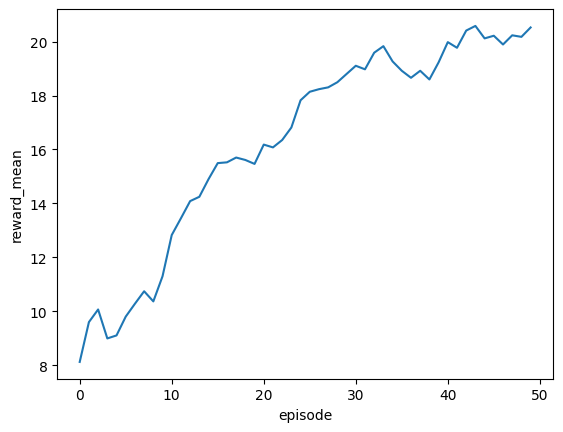

Evaluating Model


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


numsteps_mean 26.78
rewards_mean 20.155167438339916
inference_mean 0.0014026703982150666
speed_mean 20.208225567630794


In [46]:
# Create an RLlib Algorithm instance from a A2CConfig to learn how to
# act in the above environment.
config = (
    A2CConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="highway-fast-v0",
    )
    .training(microbatch_size=10)
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
# Use the config's `build()` method to construct a A2C object.
algo = config.build()
train_model(algo)

evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/a2c", num_episodes=10)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1368663) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1368663)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1368664) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1368664)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1368665) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [09:20<00:00, 11.20s/it]


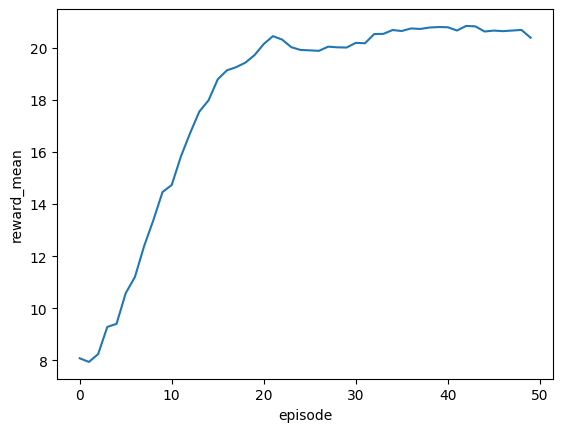

Evaluating Model


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


numsteps_mean 28.68
rewards_mean 20.88786377957264
inference_mean 0.0014042793258502476
speed_mean 20.054612406573128


In [47]:
config = (
    A3CConfig()
    .environment(
        env="highway-fast-v0"
    )
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
algo = config.build()
train_model(algo)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/a3c", num_episodes=10)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
2023-04-17 08:59:10,856	WARNING util.py:67 -- Install gputil for GPU system monitoring.


Training Model


  0%|          | 0/50 [00:00<?, ?it/s](pid=1370344) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1370344)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1370347) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1370347)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1370346) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1370346)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(Worker pid=1370344) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/uti

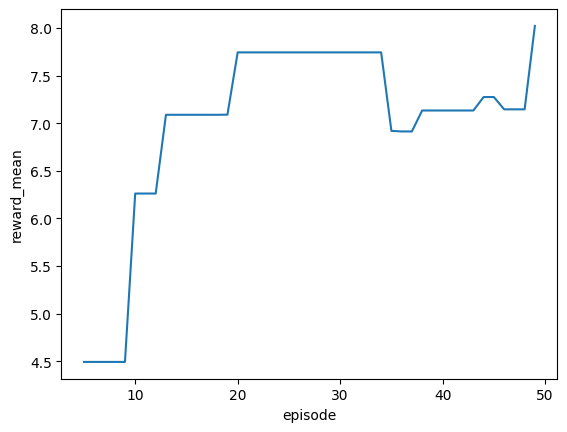

Evaluating Model


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


numsteps_mean 11.82
rewards_mean 9.560658046161858
inference_mean 0.0008653422785623584
speed_mean 23.132924806140956


In [48]:
config = (
    ARSConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="highway-fast-v0",
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
# Use the config's `build()` method to construct a PPO object.
algo = config.build()
train_model(algo)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/ars", num_episodes=10)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1371091) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1371091)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1371093) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1371093)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1371092) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [22:11<00:00, 26.63s/it]


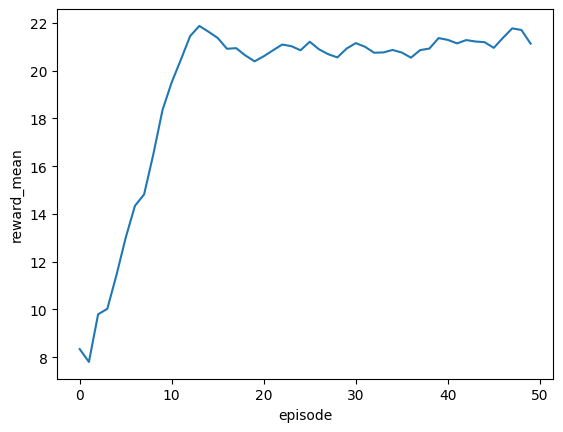

Evaluating Model


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


numsteps_mean 29.0
rewards_mean 20.615200376158892
inference_mean 0.0018702557881673178
speed_mean 20.301504165553208


In [49]:
config = (
    DQNConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="highway-fast-v0",
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
# Use the config's `build()` method to construct a PPO object.
algo = config.build()
train_model(algo)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/dqn", num_episodes=10)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1372774) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1372774)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1372776) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1372776)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1372775) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [22:23<00:00, 26.88s/it]


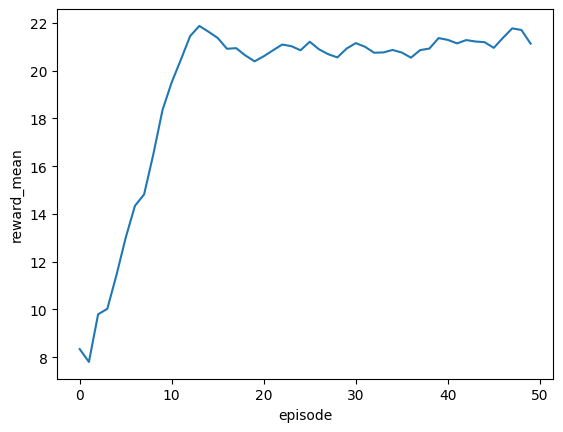

Evaluating Model


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


numsteps_mean 29.0
rewards_mean 20.615200376158892
inference_mean 0.001977405548095703
speed_mean 20.301504165553208


In [50]:
config = (
    DQNConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="highway-fast-v0"
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
config.double_q = True
# Use the config's `build()` method to construct a PPO object.
algo = config.build()
train_model(algo)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/double_dqn", num_episodes=10)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1374448) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1374448)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1374446) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1374446)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1374445) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [22:55<00:00, 27.50s/it]


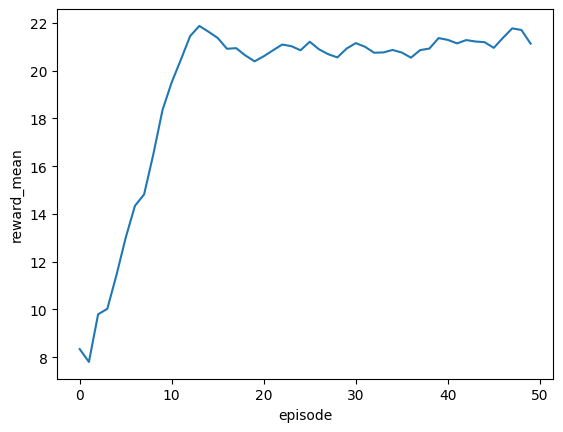

Evaluating Model


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


numsteps_mean 29.0
rewards_mean 20.615200376158892
inference_mean 0.002047824541727702
speed_mean 20.301504165553208


In [51]:
config = (
    DQNConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="highway-fast-v0"
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
config.dueling = True
# Use the config's `build()` method to construct a PPO object.
algo = config.build()
train_model(algo)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/dueling_dqn", num_episodes=10)

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 1, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'num_trainer_workers': 0, 'num_gpus_per_trainer_worker': 0, 'num_cpus_per_trainer_worker': 1, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': None, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': False, 'is_atari': None, 'auto_wrap_old_gym_envs': True, 'num_envs_per_worker': 1, 'samp

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
(pid=1376815) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1376815)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1376812) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1376812)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1376814) /home/aai/anaconda3/envs/q-le

Training Model


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


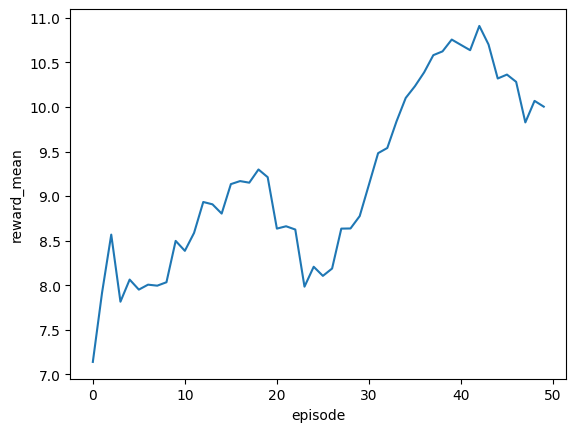

Evaluating Model


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


numsteps_mean 11.74
rewards_mean 9.735340035763597
inference_mean 0.0014522150509772907
speed_mean 23.872866719315365


In [52]:
config = SACConfig().training(gamma=0.9, lr=0.01)
config.seed = 0
config = config.resources(num_gpus=1)  
config = config.rollouts(num_rollout_workers=4)  
print(config.to_dict())  
algo = config.build(env="highway-fast-v0")  

train_model(algo, num_training_epochs=50)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/sac", num_episodes=10)

## Continuous Action Spaces

For the other methods, we have to use some environments with continuous action spaces.

In [3]:
env = gym.make("parking-v0")
num_training_epochs = 50
env.default_config()

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -500,
 'steering_range': 0.7853981633974483,
 'duration': 100,
 'controlled_vehicles': 1,
 'vehicles_count': 0,
 'add_walls': True}

In [61]:
class ContinuousRAA():
    def __init__(self, action_space) -> None:
        self.action_space = action_space
    def compute_single_action(self, state):
        return self.action_space.sample()

In [62]:
algo = ContinuousRAA(env.action_space)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/conti_raa", num_episodes=10)

Evaluating Model


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


numsteps_mean 89.36
rewards_mean -540.9825646609397
inference_mean 6.968714379272191e-05
speed_mean -0.08350908405942375


(pid=1868320) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1868320)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1868321) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1868321)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1868319) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1868319)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(RolloutWorker pid=1868319) 2023-04-18 10:07:00,519	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info

Training Model


100%|██████████| 50/50 [11:41<00:00, 14.02s/it]


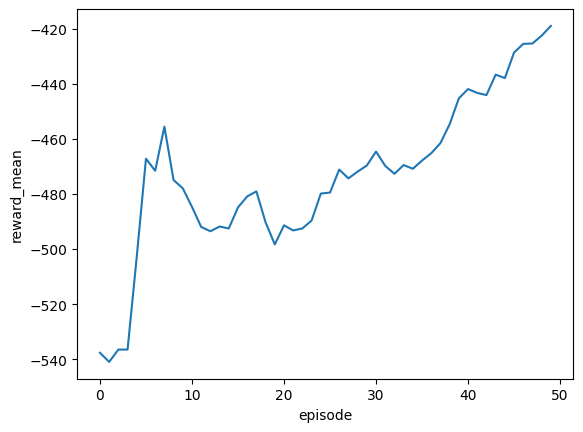

Evaluating Model


100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


numsteps_mean 343.64
rewards_mean -328.4812207406439
inference_mean 0.001849165021985797
speed_mean -0.027039306908932605


In [70]:
config = (
    DDPGConfig()
    .environment(
        env="parking-v0",
    )
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
algo = config.build()
train_model(algo, num_training_epochs=num_training_epochs)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/ddpg", num_episodes=10)

(pid=1871001) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1871001)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1870999) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1870999)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1871000) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1871000)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(RolloutWorker pid=1870999) 2023-04-18 10:24:43,525	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info

Training Model


100%|██████████| 50/50 [12:44<00:00, 15.28s/it]


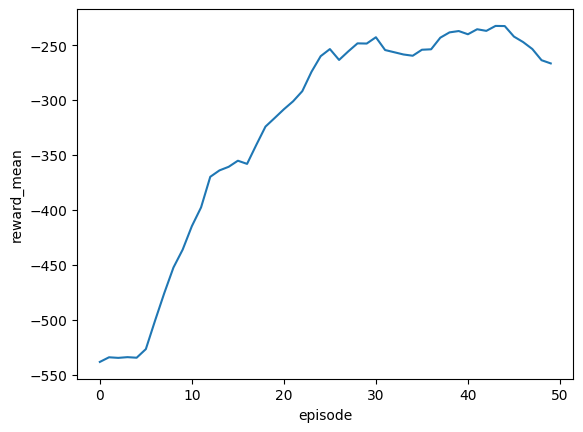

Evaluating Model


100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


numsteps_mean 399.54
rewards_mean -267.93020204607745
inference_mean 0.0015025760645682345
speed_mean -0.14446278446295271


In [71]:
config = (
    PPOConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="parking-v0",
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
# Use the config's `build()` method to construct a PPO object.
algo = config.build()
train_model(algo, num_training_epochs=num_training_epochs)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/ppo", num_episodes=10)

2023-04-18 12:29:03,291	INFO worker.py:1553 -- Started a local Ray instance.
(pid=1934228) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1934228)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1934227) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1934227)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=1934229) /home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=1934229)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(RolloutWorker pid=1934227) 2023-04-18 12:29:08,390	WARNING

Training Model


100%|██████████| 100/100 [06:13<00:00,  3.73s/it]


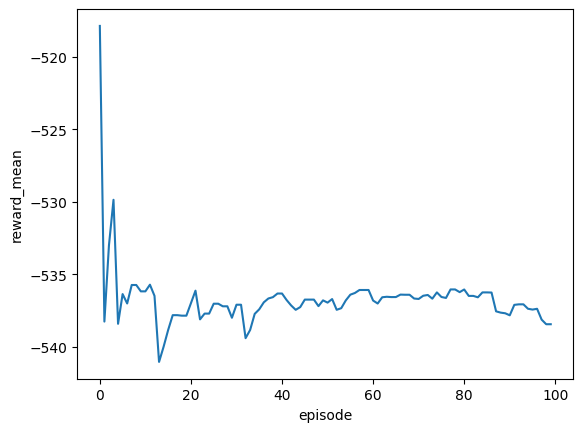

Evaluating Model


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


numsteps_mean 91.96
rewards_mean -541.8755628867448
inference_mean 0.0014568539063819714
speed_mean 0.9463806910188296


In [4]:
config = (
    SACConfig()
    .environment(
        # Env class to use (here: our gym.Env sub-class from above).
        env="parking-v0",
    )
    # Parallelize environment rollouts.
    .rollouts(num_rollout_workers=3)
    .training(gamma=0.9, lr=0.01)
)
config.seed = 0
algo = config.build(env="parking-v0")  

train_model(algo, num_training_epochs=100)
evaluate_model(algo, max_episode_num=50)
render_model(algo, output_folder="trained_models/rllib/conti_sac", num_episodes=10)

In [ ]:
config = (
    TD3Config()
    .environment(
        env="parking-v0",
    )
    .rollouts(num_rollout_workers=3)
)
config.seed = 0
algo = config.build()
train_model(algo, num_training_epochs=num_training_epochs)
evaluate_model(algo, max_episode_num=50)
render_model(algo, "trained_models/rllib/td3", num_episodes=10)